In [1]:
%cd /home/thucth/thucth/project/id_occlusion

/home/thucth/thucth/project/id_occlusion


## Prepare dataset

```
Create csv file with path _ label(float score)

Description:
- Dataset with multi level:
0: no occlusion (or occluded area is out of id)
1: 10% occlusion
2: 20% occlusion
3: 30% occlusion
4: 40% occlusion
5: 50% occlusion
.
.
```

### Inherit data from IQ006

In [321]:
import pandas as pd
import json 
categories_new = [
    {"id": 1, "name": 'corner_1'},
    {"id": 2, "name": 'corner_2'},
    {"id": 3, "name": 'corner_3'},
    {"id": 4, "name": 'corner_4'},
    {"id": 5, "name": 'full'}
]

categories_map = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'full': 5
}

categories_map_inverse = {
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "full"
}


In [322]:
import json
def read_from_cocojson(path_json):
    images_dict={}
    with open(path_json, 'r') as f:
        data = json.load(f)
        for ann in data['annotations']:
            if ann["image_id"] not in images_dict:
                images_dict[ann["image_id"]]={"bbox":{}}
            corner_type = categories_map_inverse[ann["category_id"]]
            #this is to convert from coco format into voc format
            images_dict[ann["image_id"]]["bbox"][corner_type] = [ann["bbox"][0], ann["bbox"][1], ann["bbox"][2]+ann["bbox"][0], ann["bbox"][3]+ann["bbox"][1]]

        for img in data['images']:
            images_dict[img['id']]["path"]= img["file_name"]
            images_dict[img['id']]["width"] = img["width"]
            images_dict[img['id']]["height"] = img["height"]
    voc_data = [images_dict[k] for k in images_dict.keys()]
    return voc_data

### generate clear id

In [17]:
import csv
def generate_data_clear(voc_data, path_csv):
    print("Amount of source: ", len(voc_data))
    count=0
    f = open(path_csv, 'w')
    csv_writer = csv.writer(f)
    csv_writer.writerow(['path','score'])
    for sample in voc_data:
        if  len(sample['bbox'].keys())==5: #full corner
            csv_writer.writerow([sample['path'], 0])
            count+=1
    print("Amount of target: ", count)
    f.close()

split='val'
voc_data = read_from_cocojson(path_json = "/home/thucth/thucth/project/id_fullcorner_dataprocess/json_data/original_size_%s_2702.json"%split)
generate_data_clear(voc_data, "resources/data_occlusion_%s.csv"%split)

### generate occluded id

In [404]:
from src.datasets import augment
import cv2
import os
import importlib
importlib.reload(augment)

split='test'
voc_data = read_from_cocojson(path_json = "/home/thucth/thucth/project/id_fullcorner_dataprocess/json_data/original_size_%s_2702.json"%split)
df_id_clear = pd.read_csv("resources/data_occlusion_%s_clear.csv"%split)
path_backgrounds = list(df_id_clear['path'].values)
backegrounds = augment.load_background(img_paths=path_backgrounds[:10])

foregrounds = augment.load_foreground(path="./resources/foreground_cropped")

path2bbox={}
for sample_meta in voc_data:
    path_image = os.path.basename(sample_meta['path'])
    bbox = sample_meta['bbox']
    path2bbox[path_image]=bbox

   

(388, 600, 3)
(218, 172, 4)
0.5007262167952129
(109, 86, 4)
max alpha resize_scale:  255
max alpha random_color:  255
max alpha apply_exponential:  255
max alpha rotate_image:  255
max alpha rotate_image:  255
max alpha:  255.0


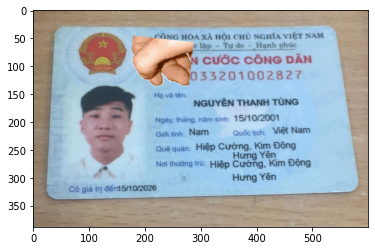

True

In [425]:
import matplotlib.pyplot as plt 

img0=backegrounds[2]
print(img0[0].shape)
# output = augment.process_wrapper(img0, foregrounds, fg_size=(112,112), path2bbox=path2bbox)
output, _ = augment.process(img0, foregrounds[2], fg_size=(112, 112), percent=0.05, path2bbox=path2bbox, is_debug=False)
plt.imshow(output)
plt.show()
cv2.imwrite("resources/test.jpg", output[:,:,::-1])

In [178]:
6*12/388/600

0.00030927835051546395

In [279]:
img = img0[0]

In [280]:
img_rgba = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)

In [290]:
img_rgba[:,:,3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [288]:
img[:,:,2]

array([[168,  75,  64, ...,  84,  76, 177],
       [149,  35,  34, ...,  40,  37, 149],
       [152,  29,  23, ...,  38,  32, 149],
       ...,
       [152,  76,  69, ...,  58,  67, 158],
       [159,  99,  89, ...,  58,  74, 158],
       [204, 165, 161, ..., 166, 165, 212]], dtype=uint8)